# JAK2 Max Analysis

In [14]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


## Imports

In [15]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from irelease.utils import generate_smiles, canonical_smiles
import nb_utils as nbu
from math import ceil
from sklearn.manifold import TSNE
import pandas as pd
import rdkit.Chem as Chem
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw

In [16]:
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

## Load SMILES files

In [17]:
ppo_grl_train = 'jak2_max/JAK2_max_IReLeaSE-PPO_with_irl.json'
ppo_grl_eval = 'jak2_max/JAK2_max_smiles_biased_ppo_grl_eval.json'
ppo_baseline_reward_train = 'jak2_max/JAK2_max_IReLeaSE-PPO__baseline_reward.json'
ppo_baseline_reward_eval = 'jak2_max/JAK2_max_smiles_biased_ppo_baseline_reward_eval.json'
reinforce_train = 'jak2_max/JAK2_max_IReLeaSE-REINFORCE_no_irl.json'
reinforce_eval = 'jak2_max/JAK2_max_smiles_biased_reinforce_eval.json'
reinforce_grl_train = 'jak2_max/JAK2_max_IReLeaSE-REINFORCE_with_irl.json'
reinforce_grl_eval = 'jak2_max/JAK2_max_smiles_biased_reinforce_grl_eval.json'

In [18]:
ppo_grl_smiles_valid,  ppo_grl_smiles_invalid = nbu.smiles_from_json_data(ppo_grl_eval)
ppo_grl_conv = nbu.get_convergence_data(ppo_grl_train)
ppo_baseline_reward_smiles_valid, ppo_baseline_reward_smiles_invalid = nbu.smiles_from_json_data(ppo_baseline_reward_eval)
ppo_baseline_reward_conv = nbu.get_convergence_data(ppo_baseline_reward_train)
reinforce_smiles_valid, reinforce_smiles_invalid = nbu.smiles_from_json_data(reinforce_eval)
reinforce_conv = nbu.get_convergence_data(reinforce_train)
reinforce_grl_smiles_valid, reinforce_grl_smiles_invalid = nbu.smiles_from_json_data(reinforce_grl_eval)
reinforce_grl_conv = nbu.get_convergence_data(reinforce_grl_train)
len(ppo_grl_smiles_valid), len(ppo_baseline_reward_smiles_valid), len(reinforce_smiles_valid), len(reinforce_grl_smiles_valid)

(5922, 6945, 6782, 7046)

In [19]:
# CSV files containing predictions/evaluations
preds_ppo_grl_eval = pd.read_csv('jak2_max/JAK2_max_smiles_biased_ppo_grl_eval.csv')
preds_ppo_baseline_reward_eval = pd.read_csv('jak2_max/JAK2_max_smiles_biased_ppo_baseline_reward_eval.csv')
preds_reinforce_eval = pd.read_csv('jak2_max/JAK2_max_smiles_biased_reinforce_eval.csv')
preds_reinforce_grl_eval = pd.read_csv('jak2_max/JAK2_max_smiles_biased_reinforce_grl_eval.csv')
preds_demo = pd.read_csv('jak2_max/jak2_max_biased.csv')
preds_unbiased = pd.read_csv('jak2_max/jak2_unbiased.csv')
preds_ppo_grl_eval.shape, preds_ppo_baseline_reward_eval.shape, preds_reinforce_eval.shape, preds_reinforce_grl_eval.shape, preds_demo.shape, preds_unbiased.shape

((5922, 2), (6945, 2), (6782, 2), (7046, 2), (10000, 2), (10000, 2))

In [20]:
preds_ppo_grl_eval.shape[0] / 10000. * 100., preds_ppo_baseline_reward_eval.shape[0] / 10000. * 100., preds_reinforce_eval.shape[0] / 10000. * 100., preds_reinforce_grl_eval.shape[0] / 10000. * 100., preds_demo.shape[0] / 10000. * 100., preds_unbiased.shape[0] / 10000. * 100.

(59.21999999999999, 69.45, 67.82000000000001, 70.46, 100.0, 100.0)

## Evaluate SMILES

In [21]:
generators = nbu.data_provider('../../data/jak2_max_smiles_biased.smi', '../../data/unbiased_smiles.smi')

In [22]:
demo_smiles = generators['demo_data'].random_training_set_smiles(10000)
demo_smiles = list(set(demo_smiles))
unbiased_smiles = generators['unbiased_data'].random_training_set_smiles(10000)
unbiased_smiles = list(set(unbiased_smiles))

In [23]:
len(preds_demo['SMILES'].unique())

3798

In [24]:
demo_smiles[0], unbiased_smiles[0]

('CCCCN1CCN(S(=O)(=O)N2CCN(S(=O)(=O)N3CCN(S(=O)(=O)N4CCNCC4)CC3)CC2)CC1',
 'CC(=O)OC1CCc2cc(F)cc(O)c2C1=O')

In [25]:
preds_ppo_grl_smiles = preds_ppo_grl_eval['prediction'].tolist()
preds_ppo_baseline_reward_smiles = preds_ppo_baseline_reward_eval['prediction'].tolist()
preds_reinforce_smiles = preds_reinforce_eval['prediction'].tolist()
preds_reinforce_grl_smiles = preds_reinforce_grl_eval['prediction'].tolist()
preds_demo_smiles = preds_demo['prediction'].tolist()
preds_unbiased_smiles = preds_unbiased['prediction'].tolist()

## KDE plots

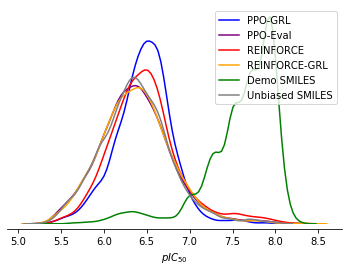

In [26]:
sns.kdeplot(preds_ppo_grl_smiles, label='PPO-GRL', shade=False, color='blue')
sns.kdeplot(preds_ppo_baseline_reward_smiles, label='PPO-Eval', shade=False, color='purple')
sns.kdeplot(preds_reinforce_smiles, label='REINFORCE', shade=False, color='red')
ax = sns.kdeplot(preds_reinforce_grl_smiles, label='REINFORCE-GRL', shade=False, color='orange')
sns.kdeplot(preds_demo_smiles, label='Demo SMILES', shade=False, color='green')
ax = sns.kdeplot(preds_unbiased_smiles, label='Unbiased SMILES', shade=False, color='gray')
plt.xlabel('$pIC_{50}$')
# ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_xticks([])
sns.despine(offset=5, left=True, bottom=False)
plt.savefig('jak2_max/jak2_max_kde_plots.pdf')
plt.show()

## Convergence plot

In [27]:
ppo_grl_biased = ppo_grl_conv['biased']
ppo_baseline_reward_biased = ppo_baseline_reward_conv['biased']
reinforce_biased = reinforce_conv['biased']
reinforce_grl_biased = reinforce_grl_conv['biased']
demo_vals = reinforce_grl_conv['demo']
unbiased_vals = reinforce_grl_conv['baseline']

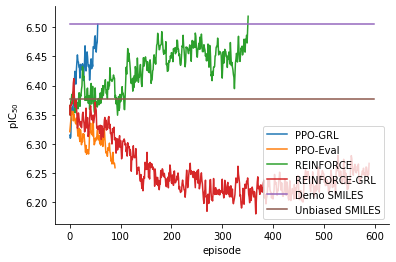

In [32]:
offset = 10
plt.plot(nbu.smoothing_values(ppo_grl_biased, 0.6)[offset:150])
plt.plot(nbu.smoothing_values(ppo_baseline_reward_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(reinforce_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(reinforce_grl_biased, 0.6)[offset:])
plt.plot(demo_vals)
plt.plot(unbiased_vals)
plt.xlabel('episode')
plt.ylabel('pIC$_{50}$')
plt.legend(['PPO-GRL','PPO-Eval','REINFORCE','REINFORCE-GRL', 'Demo SMILES', 'Unbiased SMILES'], loc='lower right')
plt.savefig('jak2_max/jak2_max_irl_vs_rl_convergence.pdf')
sns.despine()

## t-SNE plot

In [15]:
hparams = {'d_model': 1500,
            'dropout': 0.0,
            'monte_carlo_N': 5,
            'use_monte_carlo_sim': True,
            'no_mc_fill_val': 0.0,
            'gamma': 0.97,
            'episodes_to_train': 10,
            'gae_lambda': 0.95,
            'ppo_eps': 0.2,
            'ppo_batch': 1,
            'ppo_epochs': 5,
            'entropy_beta': 0.01,
            'bias_mode': 'max',
            'use_true_reward': False,
            'baseline_reward': False,
            'reward_params': {'num_layers': 2,
                              'd_model': 512,
                              'unit_type': 'gru',
                              'demo_batch_size': 32,
                              'irl_alg_num_iter': 5,
                              'dropout': 0.2,
                              'use_attention': False,
                              'use_validity_flag': True,
                              'bidirectional': True,
                              'optimizer': 'adadelta',
                              'optimizer__global__weight_decay': 0.0005,
                              'optimizer__global__lr': 0.001, },
            'agent_params': {'unit_type': 'gru',
                             'num_layers': 2,
                             'stack_width': 1500,
                             'stack_depth': 200,
                             'optimizer': 'adadelta',
                             'optimizer__global__weight_decay': 0.005,
                             'optimizer__global__lr': 0.001},
            'critic_params': {'num_layers': 2,
                              'd_model': 256,
                              'dropout': 0.2,
                              'unit_type': 'gru',
                              'optimizer': 'adam',
                              'optimizer__global__weight_decay': 0.005,
                              'optimizer__global__lr': 0.001},
            'expert_model_dir': './model_dir/expert_xgb_reg'
            }

In [16]:
init_dict = nbu.initialize(hparams, generators['demo_data'], generators['unbiased_data'], True)

In [17]:
# encoder = init_dict['encoder']
# ppo_reward_net_rnn = init_dict['reward_net_rnn']
# ppo_reward_net = init_dict['reward_net']
# ppo_reward_net.load_state_dict(nbu.load_model_weights('../model_dir/JAK2_max_irelease_stack-rnn_gru_ppo_reward_net_2020_07_12__20_54_23_1.003_66.mod'))

In [18]:
# with torch.set_grad_enabled(False):
#     reward_lst, logits_lst = [], []
#     tsne_smiles = ppo_grl_smiles_valid + ppo_grl_smiles_invalid
#     batch = 128
#     for i in range(0, len(tsne_smiles), batch):
#         inp, valid_vec = nbu.smiles_to_tensor(['<'+s+'>' for s in tsne_smiles[i:i+batch]])
#         enc_out = encoder([inp, valid_vec])
#         reward, logits = ppo_reward_net_rnn(enc_out, return_logits=True)
#         reward_lst.append(reward)
#         logits_lst.append(logits)
#     reward = torch.cat(reward_lst)
#     logits = torch.cat(logits_lst)

In [19]:
# logits.shape, reward.shape

In [20]:
# tsne_rep = TSNE(n_components=2).fit_transform(logits.detach().cpu().numpy())
# tsne_data = pd.DataFrame({'x':tsne_rep[:,0], 'y':tsne_rep[:,1]})
# tsne_rep.shape

In [21]:
# plt.figure(figsize=(10,10))
# points = plt.scatter(tsne_data['x'], tsne_data['y'], c=reward.detach().cpu().numpy().reshape(-1,), s=50, cmap="Spectral")
# cb = plt.colorbar(points, ticks=None)
# cb.outline.set_visible(False)
# ax = sns.scatterplot(x="x", y="y", hue=reward.detach().cpu().numpy().reshape(-1,), data=tsne_data, 
#                     legend=False, palette='Spectral', edgecolor='black', linewidth=.01)
# v = []
# # valid SMILES
# while True:
#     va_idx = np.random.randint(len(ppo_grl_smiles_valid))
#     comp = ppo_grl_smiles_valid[va_idx]
#     i = len(v)+1
#     if len(comp) <= 50:
#         v.append(comp)
#         ax.annotate('val-'+str(i), xy=(tsne_data['x'][va_idx], tsne_data['y'][va_idx]), 
#                     xytext=(-20+(i*10),50), 
#                     arrowprops=dict(facecolor='black', arrowstyle='-'),
#                    horizontalalignment='right', verticalalignment='top')
#         if len(v) == 3:
#             break

# inv = []
# # invalid SMILES
# for i in range(3):
#     inv_idx = np.random.randint(len(ppo_grl_smiles_invalid))
#     inv.append(ppo_grl_smiles_invalid[inv_idx])
#     ax.annotate('inv-'+str(i+1), xy=(tsne_data['x'][len(ppo_grl_smiles_valid) + inv_idx], 
#                     tsne_data['y'][len(ppo_grl_smiles_valid) + inv_idx]), 
#                 xytext=(-50+(i*10),40), arrowprops=dict(facecolor='black', arrowstyle='-'),
#                horizontalalignment='right', verticalalignment='top')

# print('selected valid:\n', v)
# print('selected invalid:\n', inv)
# plt.axis('off')
# plt.savefig('jak2_max/jak2_max_ppo_grl_tsne.pdf')
# plt.show()

##  Draw random SMILES

In [22]:
vis_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in set(ppo_grl_smiles_valid) if len(sm)]# <= 50]
sanitized_gen_mols = [vis_mols[i] for i in np.where(np.array(vis_mols) != None)[0]]
len(sanitized_gen_mols)

5911

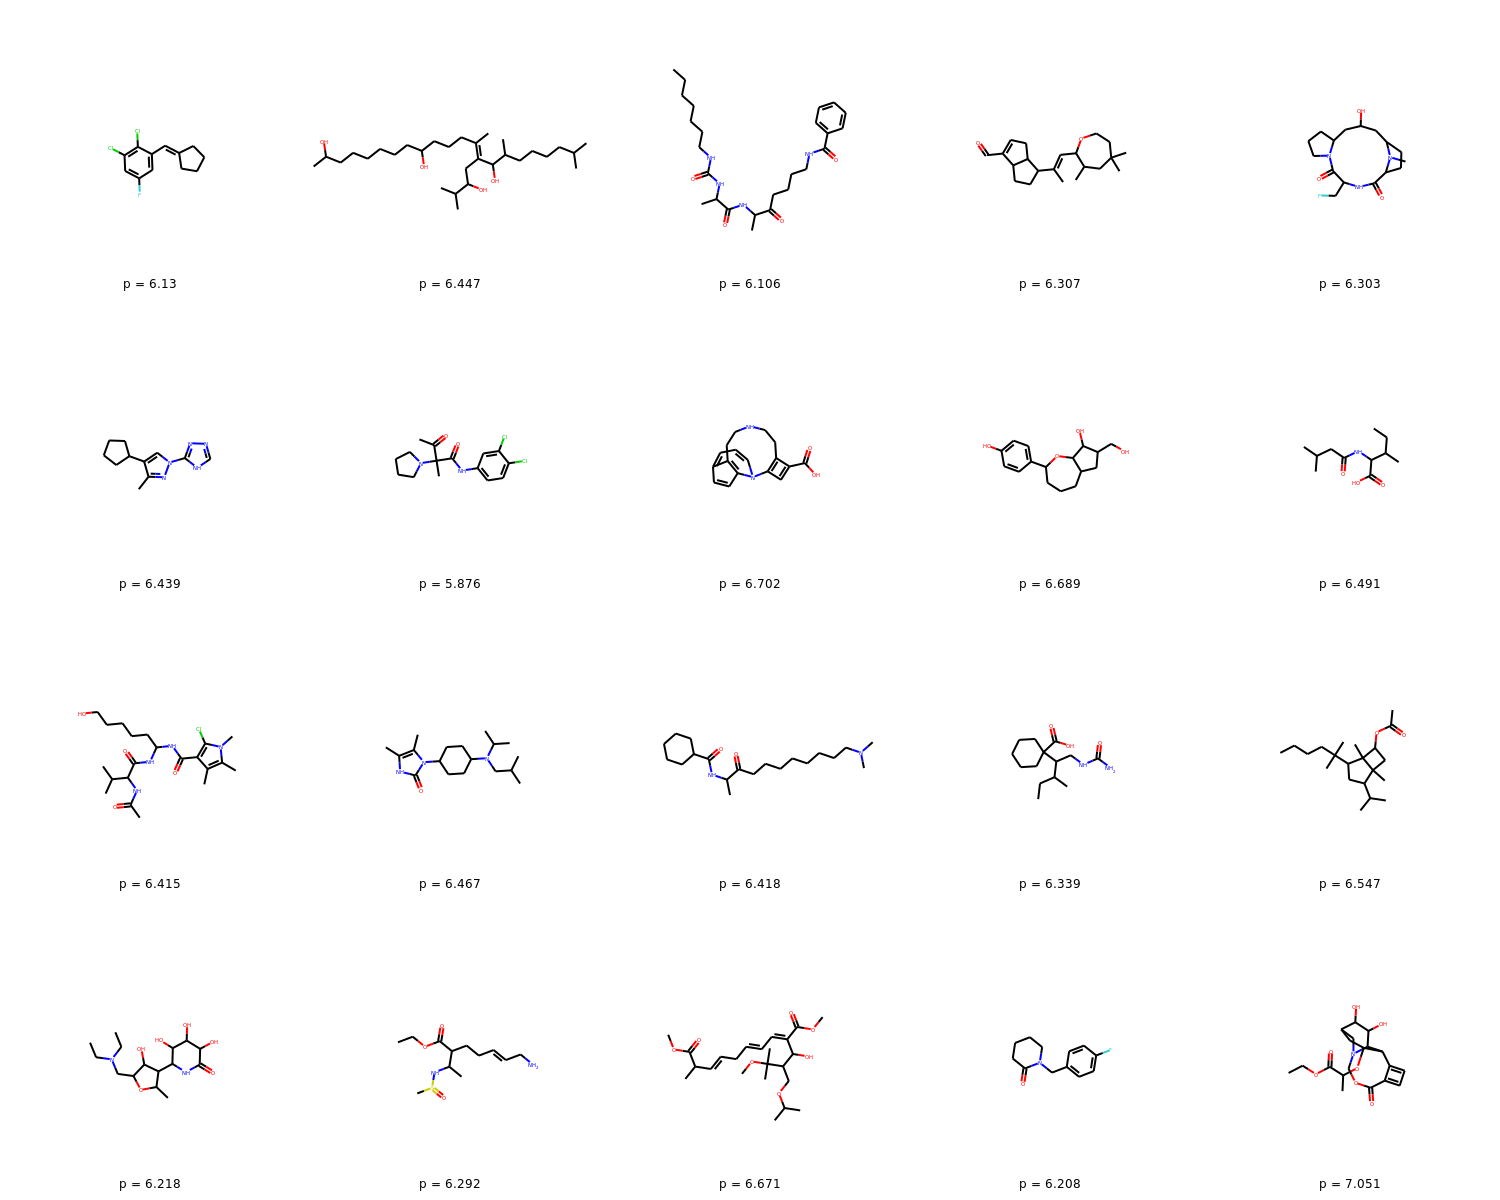

In [23]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['p = ' + str(round(float(preds_ppo_grl_smiles[i]), 3)) for i in ind]
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(300,300), legends=legends)

In [24]:
for i, mol in enumerate(mols_to_draw):
    print(f'{Chem.MolToSmiles(mol)}\t\t{legends[i]}')

Fc1cc(Cl)c(Cl)c(C=C2CCCC2)c1		p = 6.13
CC(CCCC(O)CCCCCCC(C)O)=C(CC(O)C(C)C)C(O)C(C)CCCCC(C)C		p = 6.447
CCCCCCCNC(=O)NC(C)C(=O)NC(C)C(=O)CCCCNC(=O)c1ccccc1		p = 6.106
CC(=CC1OCCC(C)(C)CC1C)C1CCC2C(C=O)=CCC12		p = 6.307
CN1C2CCC1C(=O)NC(CF)C(=O)N1CCCC1CC(O)C2		p = 6.303
Cc1nn(-c2nnc[nH]2)cc1C1CCCC1		p = 6.439
CC(=O)C(C)(C(=O)Nc1ccc(Cl)c(Cl)c1)N1CCCC1		p = 5.876
O=C(O)C1=CC2=C1CCNCCC1=C3C=CC1=CC=CN32		p = 6.702
OCC1CC2CCCC(c3ccc(O)cc3)OC2C1O		p = 6.689
CCC(C)C(NC(=O)CC(C)C)C(=O)O		p = 6.491
CC(=O)NC(C(=O)NC(CCCCCO)NC(=O)c1c(C)c(C)n(C)c1Cl)C(C)C		p = 6.415
Cc1[nH]c(=O)n(C2CCC(N(CC(C)C)C(C)C)CC2)c1C		p = 6.467
CC(NC(=O)C1CCCCC1)C(=O)CCCCCCCCN(C)C		p = 6.418
CCC(C)C(CNC(N)=O)C1(C(=O)O)CCCCC1		p = 6.339
CCCCC(C)(C)C1CC(C(C)C)C2(C)CC(OC(C)=O)C12C		p = 6.547
CCN(CC)CC1OC(C)C(C2NC(=O)C(O)C(O)C2O)C1O		p = 6.218
CCOC(=O)C(CCC=CCN)C(C)NS(C)=O		p = 6.292
COC(=O)C(=CC=CCC=CC(C)C(=O)OC)C(O)C(COC(C)C)C(C)(C)OC		p = 6.671
O=C1CCCCN1Cc1ccc(F)cc1		p = 6.208
CCOC(=O)C(C)OC1CC2CN3COC(=O)C4=CC=C4C1C3C(O)C2O

In [25]:
# Save selected compounds to file
# os.makedirs('./drd2_samples', exist_ok=True)
# for i, mol in enumerate(mols_to_draw):
#     Draw.MolToImageFile(mol, f'./drd2/sample_compound_{i+1}.png')

## Molecule metrics

In [62]:
def mol_metrics(df):
    results = {}
    num_can = 0
    for idx, df_smiles in enumerate([df, df[df['prediction'] >= np.mean(demo_vals)]]):
        new_smiles, valid_vec = canonical_smiles(df_smiles['SMILES'].tolist())
        smiles = []
        for i, s in enumerate(new_smiles):
            if valid_vec[i] == 1:
                smiles.append(s)
        eval_dict = nbu.evaluate(smiles, demo_smiles)
        eval_dict['Num of unique canonical SMILES'] = len(set(smiles))
        if idx==0:
            num_can = len(smiles)
        eval_dict['percentage of valid'] = df_smiles.shape[0] / 10000. * 100.
        if idx==1:            
            eval_dict['percentage in threshold (canonical)'] = len(smiles) / num_can
        results['no_threshold' if idx==0 else 'with_threshold'] = eval_dict
    return results

In [63]:
mol_metrics(preds_ppo_grl_eval)

{'no_threshold': {'novelty': 0.9996615332543578,
  'hard_novelty': 0.9996615332543578,
  'soft_novelty': 0.9997630732780505,
  'external_diversity': 0.6143007767760873,
  'internal_diversity': 0.9282383581706759,
  'conciseness': 1.0,
  'solubility': 0.5867584584309109,
  'naturalness': 0.6638868242815626,
  'synthesizability': 0.46794785139175094,
  'druglikeliness': 0.5806874974166699,
  'Num of unique canonical SMILES': 5911,
  'percentage of valid': 59.21999999999999},
 'with_threshold': {'novelty': 0.9996387283236994,
  'hard_novelty': 0.9996387283236994,
  'soft_novelty': 0.9997471098265897,
  'external_diversity': 0.5425195294212152,
  'internal_diversity': 0.9246692084429076,
  'conciseness': 1.0,
  'solubility': 0.578434187914398,
  'naturalness': 0.6997524267965779,
  'synthesizability': 0.3759222757722638,
  'druglikeliness': 0.5325428116276686,
  'Num of unique canonical SMILES': 2768,
  'percentage of valid': 27.76,
  'percentage in threshold (canonical)': 0.46827947893757

In [64]:
mol_metrics(preds_ppo_baseline_reward_eval)

{'no_threshold': {'novelty': 0.9998558038932949,
  'hard_novelty': 0.9998558038932949,
  'soft_novelty': 0.9998990627253065,
  'external_diversity': 0.3859082146768098,
  'internal_diversity': 0.9174276189887793,
  'conciseness': 1.0,
  'solubility': 0.6573731416251379,
  'naturalness': 0.5541679000782829,
  'synthesizability': 0.6438921142144859,
  'druglikeliness': 0.6044093563024587,
  'Num of unique canonical SMILES': 6937,
  'percentage of valid': 69.45},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.36922705015568374,
  'internal_diversity': 0.9164862209166749,
  'conciseness': 1.0,
  'solubility': 0.6403190797986957,
  'naturalness': 0.5641926460439066,
  'synthesizability': 0.56514701476311,
  'druglikeliness': 0.5757877486378473,
  'Num of unique canonical SMILES': 2427,
  'percentage of valid': 24.33,
  'percentage in threshold (canonical)': 0.3498630531930229}}

In [65]:
mol_metrics(preds_reinforce_eval)

{'no_threshold': {'novelty': 0.9994088087496305,
  'hard_novelty': 0.9994088087496305,
  'soft_novelty': 0.9995861661247414,
  'external_diversity': 0.35091880024459476,
  'internal_diversity': 0.9156004867547303,
  'conciseness': 1.0,
  'solubility': 0.6083063601491883,
  'naturalness': 0.6080352452868083,
  'synthesizability': 0.5286519833816157,
  'druglikeliness': 0.6265358440985416,
  'Num of unique canonical SMILES': 6768,
  'percentage of valid': 67.82000000000001},
 'with_threshold': {'novelty': 0.9996600951733514,
  'hard_novelty': 0.9996600951733514,
  'soft_novelty': 0.999762066621346,
  'external_diversity': 0.2806982120858218,
  'internal_diversity': 0.9120040573048571,
  'conciseness': 1.0,
  'solubility': 0.5860284383227051,
  'naturalness': 0.6089797656130561,
  'synthesizability': 0.46234789745705723,
  'druglikeliness': 0.6051846554673815,
  'Num of unique canonical SMILES': 2942,
  'percentage of valid': 29.509999999999998,
  'percentage in threshold (canonical)': 0.

In [66]:
mol_metrics(preds_reinforce_grl_eval)

{'no_threshold': {'novelty': 0.9998578939889158,
  'hard_novelty': 0.9998578939889158,
  'soft_novelty': 0.9999005257922411,
  'external_diversity': 0.3813502115627386,
  'internal_diversity': 0.9172103770881908,
  'conciseness': 1.0,
  'solubility': 0.6582503382365282,
  'naturalness': 0.5552509018032847,
  'synthesizability': 0.6442857132745173,
  'druglikeliness': 0.6067871530877008,
  'Num of unique canonical SMILES': 7039,
  'percentage of valid': 70.46},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.3546940824985614,
  'internal_diversity': 0.9158188572111808,
  'conciseness': 1.0,
  'solubility': 0.6441116167041047,
  'naturalness': 0.5614737942960732,
  'synthesizability': 0.5679028956729744,
  'druglikeliness': 0.5771666350348618,
  'Num of unique canonical SMILES': 2508,
  'percentage of valid': 25.11,
  'percentage in threshold (canonical)': 0.3563006108822276}}

In [67]:
mol_metrics(preds_demo)

{'no_threshold': {'novelty': 0.16088194957273974,
  'hard_novelty': 0.16088194957273974,
  'soft_novelty': 0.4126173647009177,
  'external_diversity': 0.026940230846601725,
  'internal_diversity': 0.8045299367213459,
  'conciseness': 1.0,
  'solubility': 0.08266411360201299,
  'naturalness': 0.4854821712502277,
  'synthesizability': 0.5594017756940282,
  'druglikeliness': 0.48300095516534874,
  'Num of unique canonical SMILES': 3608,
  'percentage of valid': 100.0},
 'with_threshold': {'novelty': 0.1503742844561867,
  'hard_novelty': 0.1503742844561867,
  'soft_novelty': 0.40526199911933064,
  'external_diversity': 0.0068651832692829505,
  'internal_diversity': 0.7941115523601611,
  'conciseness': 1.0,
  'solubility': 0.07337925219719711,
  'naturalness': 0.4821139374140754,
  'synthesizability': 0.5603077069067253,
  'druglikeliness': 0.4787743582964644,
  'Num of unique canonical SMILES': 3449,
  'percentage of valid': 95.7,
  'percentage in threshold (canonical)': 0.958022093634929}

In [68]:
mol_metrics(preds_unbiased)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.3792674219122904,
  'internal_diversity': 0.9172093645408316,
  'conciseness': 1.0,
  'solubility': 0.6537168149513535,
  'naturalness': 0.554249677373528,
  'synthesizability': 0.6410245249259279,
  'druglikeliness': 0.6037894919031428,
  'Num of unique canonical SMILES': 2050,
  'percentage of valid': 100.0},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.3598633249269879,
  'internal_diversity': 0.9160876773080566,
  'conciseness': 1.0,
  'solubility': 0.6392547344630046,
  'naturalness': 0.5723041129480143,
  'synthesizability': 0.565014702906119,
  'druglikeliness': 0.5720246824427468,
  'Num of unique canonical SMILES': 717,
  'percentage of valid': 35.370000000000005,
  'percentage in threshold (canonical)': 0.3537}}

## RNN hidden neurons examination

In [33]:
# def plot_heatmap(smiles_list, logits, neuron=None, save=False):
#     if neuron is None:
#         neuron = np.random.randint(logits.shape[-1])
#     print(f'Plotting for neuron {neuron}')
#     for i, smiles in enumerate(smiles_list):
#         arr = logits[:len(smiles), i, neuron].reshape(1, len(smiles))
#         chars = np.array([c for c in smiles]).reshape(1,-1)
#         fig = plt.figure(figsize=(200,4))
#         sns.heatmap(arr, annot=chars, fmt='', cbar=False, 
#                     cmap=sns.color_palette("bwr", 10), annot_kws={'size':100, 'fontweight':'normal'},
#                    xticklabels=False, yticklabels=False, square=True)
#         if save:
#             os.makedirs(f'drd2/neuron_{neuron}', exist_ok=True)
#             plt.savefig(f'drd2/neuron_{neuron}/{i}.png')
#         plt.show()

In [34]:
# plot_heatmap(ppo_samples[:10], ppo_samples_neurons[:,:10,:])